In [181]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, precision_score, classification_report, \
    confusion_matrix, recall_score, accuracy_score

In [182]:
from nltk.tokenize import SpaceTokenizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import re

import xgboost as xgb
xgb.set_config(verbosity=0)

%matplotlib inline
import matplotlib.pyplot as plt

Источник Датасета - https://archive.ics.uci.edu/ml/datasets/Online+Retail

In [184]:
df = pd.read_excel('C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/Lectures/Lectures_6/HomeWork/Online-Retail.xlsx')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [185]:
len(df[df["CustomerID"].isnull()])

135080

Так как нас интересует работа в дальнейшем с известными нам пользователями удалим случайных покупателей.

In [186]:
df.dropna(subset=['CustomerID'], inplace=True)

In [187]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [188]:
len(df)

406829

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [190]:
df = df.astype({'CustomerID': np.int32})

In [191]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


Посмотрим на страновое распределение покупателей

In [192]:
df['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [193]:
df['Country'].describe()

count             406829
unique                37
top       United Kingdom
freq              361878
Name: Country, dtype: object

Доминирующее положение представителей United Kingdom.

In [194]:
import nltk
from nltk.corpus import stopwords

In [195]:
stopword = stopwords.words('english')
print(len(stopword))

179


Пусть по техзаданию заказчика требуется найти 3000 покупателей кому можно сделать предложение о поступлении новинки в чайном ассортименте магазина. Требуется найти среди покупателей целевую группу для проведения маркетинговой акции.

In [196]:
product_search = 'tea'

Почистим поле Description и добавим дополнительный столбец "метку" класса.

In [197]:
def lower_text(text):
    '''
    перевод текста в нижний регистр и удаление ненужных символов в названии товара
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|", '', text)
    text = re.sub("[+=]|[||/]|", '', text)
    
    return text

In [198]:
def text_without_stopword(text):    
    '''
    избавляемся от стоп-слов
    '''
    if not isinstance(text, str):
        text = str(text)
    
    words = SpaceTokenizer().tokenize(text)

    words_lem_without_stopwords = [i for i in words if not i in stopword]
    
    return " ".join(words_lem_without_stopwords)

In [199]:
def rule(x, y):
    return 1 if x in y else 0

In [200]:
df['Description'] = df['Description'].apply(lambda x: lower_text(x))

In [201]:
df['Description'] = df['Description'].apply(lambda x: text_without_stopword(x))

In [202]:
df['flag'] = df['Description'].apply(lambda y: rule(product_search,y))

In [203]:
df.loc[df['flag']==1].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,flag
14,536367,84969,box assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,1
33,536370,21035,set red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,France,1
40,536370,22900,set tea towels love london,24,2010-12-01 08:45:00,2.95,12583,France,1


Количество уникальных покупателей

In [204]:
len(df['CustomerID'].unique())

4372

Количество покупателей искомого товара и кол-во уникальных покупателей

In [205]:
df_p = df.loc[df['flag']==1]

In [206]:
df_p.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,flag
14,536367,84969,box assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,1
33,536370,21035,set red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,France,1
40,536370,22900,set tea towels love london,24,2010-12-01 08:45:00,2.95,12583,France,1
82,536376,22114,hot water bottle tea sympathy,48,2010-12-01 09:32:00,3.45,15291,United Kingdom,1
99,536378,84991,teatime fairy cake cases,24,2010-12-01 09:37:00,0.55,14688,United Kingdom,1


In [207]:
len(df_p)

14079

In [208]:
len(df_p['CustomerID'].unique())

2564

In [209]:
len(df[df['flag'] == 1]['CustomerID'].unique())

2564

Имеем 2564 любителей чая, которые уже раньше покупали чай или принадлежности для чайной церемонии.

Нам необходимо найти недостающее кол-во (3500-2564=936 чел.), которые с большой вероятностью положительно откликнутся на предложение и купят новинку.

Создадим DataFrame где каждому уникальному покупателю сопоставим все его покупки и обозначим полем флаг отметку о покупке чая, либо предметов для чайной церемонии.

In [210]:
X = df.groupby(['CustomerID']).agg({
    'Description': lambda x: list(x),
    'flag': lambda x: max(x)
})

X['CustomerID'] = [i for i in X.index.values]
X.columns = ['Description', 'flag', 'CustomerID']
X = X[['CustomerID', 'Description', 'flag']]
X.index = range(len(X))
X.head(3)

,CustomerID,Description,flag
0,12346,"[medium ceramic top storage jar, medium cerami...",0
1,12347,"[black candelabra tlight holder, airline bag v...",1
2,12348,"[ sweetheart fairy cake cases, cake cases dol...",1


Посмотрим на соотношение классов (P vs U), где P - позитивы и U - все остальные неразмеченные данные

In [211]:
X['flag'].value_counts()

1    2564
0    1808
Name: flag, dtype: int64

In [212]:
X['Description'] = X['Description'].apply(lambda x: " ".join(x), 1)
X.head()

,CustomerID,Description,flag
0,12346,medium ceramic top storage jar medium ceramic ...,0
1,12347,black candelabra tlight holder airline bag vin...,1
2,12348,sweetheart fairy cake cases cake cases dolly...,1
3,12349,parisienne curio cabinet sweetheart wall tidy ...,1
4,12350,chocolate way metal sign metal sign neighbourh...,1


Для поиска недостающих участников рекламной акции будем используем обычный random negative sample.

In [213]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X, X['flag'], random_state=42)

У нас есть разметка (известные позитивы) и поле Description (список покупок) из которого мы можем извлекать признаки. В качестве признаков будем использовать tfidf

In [214]:
# Напишем класс для выбора нужного поля Description
# Cоберем наш pipeline на модели LogisticRegression. 

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

pipeline = Pipeline([('description_selector', FeatureSelector(column='Description')), 
                     ('description_tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression())])

In [215]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('description_selector', FeatureSelector(column='Description')),
                ('description_tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [216]:
tfidf = pipeline.named_steps['description_tfidf']
len(tfidf.get_feature_names_out())

2012

In [217]:
df_ = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(X_test['Description'].iloc[:10]))
df_ = pd.DataFrame(df_)
df_.columns = tfidf.get_feature_names_out()
df_

,abc,abstract,acapulco,account,acrylic,address,ade,adult,advent,afghan,...,xcm,xmas,xxcm,yellow,yellowblue,yelloworange,yellowpink,yuletide,zinc,zincglass
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245116,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.031723,0.0,0.0,0.0,0.0,0.132188,0.0
4,0.000000,0.0,0.392983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.037330,0.0
5,0.082527,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
8,0.000000,0.0,0.038336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.026218,0.0,0.0,0.0,0.0,0.043699,0.0
9,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


Получим прогнозы для "тестовой" выборки

In [218]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.52898765, 0.903836  , 0.3509202 , 0.54558169, 0.72713458,
       0.7024318 , 0.83019104, 0.96294191, 0.6871993 , 0.33563558])

Посмотрим метрики

In [219]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.510569711880985, F-Score=0.891, Precision=0.896, Recall=0.886


Довольно неплохие результаты. 
Для целей задачи "проскорим" всю выборку и отсортируем по убыванию прогноза (ведь нам в итоге нужно взять топ 3500 пользователей для рекламных целей).

In [220]:
X['y_pred'] = pipeline.predict_proba(X)[:, 1]
X = X.sort_values('y_pred', ascending=False)
X.head(3)

,CustomerID,Description,flag,y_pred
3192,16670,red hanging heart tlight holder doormat englis...,1,0.999847
3656,17315,dairy maid stripe mug natural slate rectangle ...,1,0.999619
3383,16923,antique silver tea glass etched christmas deco...,1,0.999594


Работа выполнена. Берем первые 3500 с начала списка и предлагаем им участвовать в рекламной кампании.

In [221]:
selected_users = X.iloc[:3500]['CustomerID'].values

In [222]:
X[X['CustomerID'].isin(selected_users)].head(5)

,CustomerID,Description,flag,y_pred
3192,16670,red hanging heart tlight holder doormat englis...,1,0.999847
3656,17315,dairy maid stripe mug natural slate rectangle ...,1,0.999619
3383,16923,antique silver tea glass etched christmas deco...,1,0.999594
1895,14911,rose cottage keepsake box blue charlielola pe...,1,0.999547
1883,14895,glass jar kings choice wooden box advent calen...,1,0.999422


In [223]:
X[X['CustomerID'].isin(selected_users)].tail(5)

,CustomerID,Description,flag,y_pred
571,13092,nurse's bag soft toy tool box soft toy doctor...,1,0.224026
3916,17666,glitter christmas star glitter christmas tree...,0,0.223536
2115,15212,mini cake stand hanging cakes ceramic cake sta...,0,0.223523
1917,14950,red diner wall clock pink diner wall clock min...,0,0.223178
1347,14158,heart decoration rustic hanging star decorati...,0,0.222422


In [224]:
df[df['CustomerID'].isin(selected_users)]['Country'].value_counts(normalize=True)

United Kingdom          0.889174
Germany                 0.023208
France                  0.021040
EIRE                    0.018912
Spain                   0.006178
Netherlands             0.005976
Belgium                 0.005089
Switzerland             0.004664
Portugal                0.003547
Australia               0.003115
Norway                  0.002716
Italy                   0.001999
Channel Islands         0.001837
Finland                 0.001604
Cyprus                  0.001572
Sweden                  0.001114
Austria                 0.000978
Denmark                 0.000940
Poland                  0.000857
USA                     0.000735
Japan                   0.000665
Israel                  0.000627
Unspecified             0.000617
Singapore               0.000579
Iceland                 0.000460
Canada                  0.000379
Malta                   0.000321
Greece                  0.000313
United Arab Emirates    0.000172
European Community      0.000154
RSA       

Не смотря на доминирующее положение в датасете, жители туманного "Альбиона" подтвердили статус чаелюбов.

Посмотрим на feature_importances

In [225]:
feature_names = pipeline.named_steps["description_tfidf"].get_feature_names_out()
feature_weights = pipeline.named_steps["clf"].coef_[0]

weights = pd.DataFrame({
    'feature_name': feature_names,
    'feature_weight': feature_weights
}).sort_values('feature_weight', ascending=False)

# топ 100 слов
weights['feature_name'].iloc[:100].values

array(['tea', 'regency', 'saucer', 'teacup', 'teatime', 'pc', 'set',
       'time', 'towels', 'cases', 'roses', 'glass', 'engraved', 'card',
       'retrospot', 'chateau', 'sympathy', 'ceramic', 'hook', 'kneeling',
       'gardeners', 'teapot', 'silver', 'french', 'pantry', 'design',
       'art', 'cake', 'pad', 'metal', 'fairy', 'small', 'mug', 'hot',
       'sugar', 'etched', 'water', 'teacoffeesugar', 'green', 'tealight',
       'bottle', 'hanger', 'london', 'pink', 'party', 'sign', 'doilies',
       'magnets', 'blue', 'shed', 'box', 'wall', 'birthday',
       'traditional', 'cup', 'stop', 'six', 'potting', 'towel', 'bag',
       'love', 'vintage', 'charlotte', 'red', 'led', 'white', 'stand',
       'plate', 'poorly', 'bracelet', 'oven', 'finish', 'babushka',
       'notebook', 'elephant', 'dolly', 'bowl', 'pot', 'angel', 'leaf',
       'tall', 'dairy', 'maid', 'chocolate', 'board', 'drawer',
       'stickers', 'candle', 'antique', 'wicker', 'embossed', 'retro',
       'empire', 'ca

Ожидаемо, что лидирующие позиции занимают товары относящиеся напрямую к слову "чай" или к чайной церемонии - "блюдце", "чайная чашка", "чаепитие", "набор".

Конечно, "United Kingdom" по распределению в категории "Country" занимает явно доминирующее положение, но это лишний раз продемонстрировало любовь британцев к этому напитку.

В рекламе одна из важнейших прикладных задач - lookalike. Часто она решается именно как задача P(ositive)U(nlabeled).

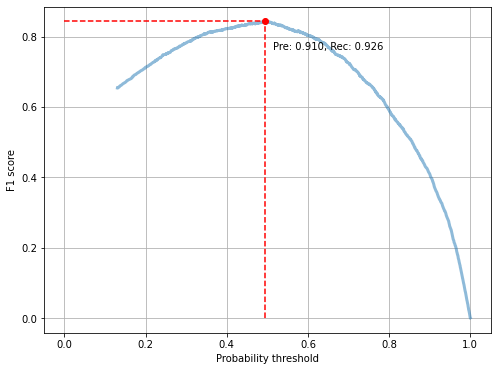

In [226]:
# Plot the class probabilities for the unlabeled samples
fig = plt.figure(figsize=(8, 6))

precision, recall, th = precision_recall_curve(X['flag'], X['y_pred'])
ax = fig.add_subplot()
f1s = precision[:-1] * recall[:-1]
ax.plot(th, f1s, lw=3, alpha=0.5)

best_th = np.argmax(f1s)
ax.plot(th[best_th], f1s[best_th], c='r', marker='o')
ax.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
ax.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
ax.annotate(f'Pre: {precision[best_th]:.3f}, Rec: {recall[best_th]:.3f}', 
             xy=(th[best_th]+ 0.02, f1s[best_th]-0.08))
ax.set_ylabel('F1 score')
ax.set_xlabel('Probability threshold')
plt.grid()


### 2. Обучим на начальных данных классификатор RandomForestClassifier

In [227]:
def evaluate_results(y_test, y_predict):
    f1 = f1_score(y_test, y_predict)
    roc = roc_auc_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict, average='binary')
    prc = precision_score(y_test, y_predict, average='binary')
    return (f1, roc, rec, prc)

In [228]:
X.drop(columns=['y_pred'], axis=1, inplace=True)
X.head(3)

,CustomerID,Description,flag
3192,16670,red hanging heart tlight holder doormat englis...,1
3656,17315,dairy maid stripe mug natural slate rectangle ...,1
3383,16923,antique silver tea glass etched christmas deco...,1


In [229]:
# разделим данные на train/test
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, X['flag'], random_state=42)

In [230]:
pipeline_RF = Pipeline([('description_selector', FeatureSelector(column='Description')), 
                     ('description_tfidf', TfidfVectorizer()), 
                     ('clf', RandomForestClassifier())])

In [231]:
# обучим наш пайплайн
pipeline_RF.fit(X_train_RF, y_train_RF)

Pipeline(steps=[('description_selector', FeatureSelector(column='Description')),
                ('description_tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [232]:
# наши прогнозы для тестовой выборки
preds_RF = pipeline.predict_proba(X_test_RF)[:, 1]
preds_RF[:10]

array([0.68909116, 0.96888645, 0.96706609, 0.97002198, 0.1694268 ,
       0.96452589, 0.9258048 , 0.4654688 , 0.39911062, 0.07748535])

In [233]:
precision, recall, thresholds = precision_recall_curve(y_test_RF, preds_RF)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.5142639366859706, F-Score=0.931, Precision=0.917, Recall=0.945


Метрики заметно лучше чем у LogisticRegression

In [234]:
feature_names_RF = pipeline_RF.named_steps["description_tfidf"].get_feature_names_out()
feature_weights_RF = pipeline_RF.named_steps["clf"].feature_importances_

weights_RF = pd.DataFrame({
    'feature_name': feature_names_RF,
    'feature_weight': feature_weights_RF
}).sort_values('feature_weight', ascending=False)

# топ 100 слов
weights_RF['feature_name'].iloc[:100].values

array(['tea', 'saucer', 'glass', 'time', 'pantry', 'set', 'regency',
       'cake', 'pc', 'teatime', 'teacup', 'roses', 'towels', 'box',
       'cases', 'retrospot', 'design', 'pink', 'green', 'fairy', 'cup',
       'red', 'rose', 'small', 'bowl', 'ceramic', 'cakestand', 'bottle',
       'party', 'pack', 'sympathy', 'tier', 'chocolate', 'blue', 'ivory',
       'holder', 'tins', 'hot', 'teapot', 'baking', 'doilies', 'tlight',
       'vintage', 'mini', 'love', 'metal', 'plate', 'silver', 'large',
       'coffee', 'tin', 'hook', 'milk', 'antique', 'paper', 'mug', 'sign',
       'flower', 'jam', 'heart', 'engraved', 'sugar', 'classic',
       'candles', 'water', 'white', 'hanging', 'dolly', 'spaceboy', 'dog',
       'christmas', 'black', 'kneeling', 'chateau', 'bunting', 'card',
       'tealight', 'shed', 'hanger', 'gardeners', 'apples', 'jug',
       'wicker', 'colour', 'traditional', 'bag', 'girl', 'home',
       'polkadot', 'stand', 'sweet', 'etched', 'hearts', 'wooden', 'gift',
       

Те же лидирующие позиции предметов из чайных церемоний и вечерних посиделок за чашечкой чая.

In [235]:
X['y_pred'] = pipeline_RF.predict_proba(X)[:, 1]
X = X.sort_values('y_pred', ascending=False)
X.head(3)

,CustomerID,Description,flag,y_pred
3192,16670,red hanging heart tlight holder doormat englis...,1,1.0
1645,14562,hanging jam jar tlight holder home sweet home ...,1,1.0
2285,15436,bright blues ribbons ribbons rustic charm pa...,1,1.0


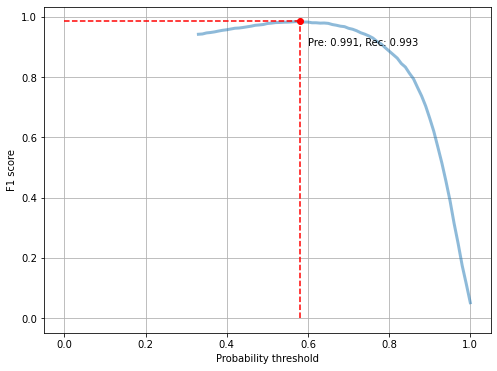

In [236]:
# Plot the class probabilities for the unlabeled samples
fig = plt.figure(figsize=(8, 6))

precision, recall, th = precision_recall_curve(X['flag'], X['y_pred'])
ax = fig.add_subplot()
f1s = precision[:-1] * recall[:-1]
ax.plot(th, f1s, lw=3, alpha=0.5)

best_th = np.argmax(f1s)
ax.plot(th[best_th], f1s[best_th], c='r', marker='o')
ax.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
ax.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
ax.annotate(f'Pre: {precision[best_th]:.3f}, Rec: {recall[best_th]:.3f}', 
             xy=(th[best_th]+ 0.02, f1s[best_th]-0.08))
ax.set_ylabel('F1 score')
ax.set_xlabel('Probability threshold')
plt.grid()


In [237]:
X.drop(columns=['y_pred'],axis = 1, inplace=True)
X.head(3)

,CustomerID,Description,flag
3192,16670,red hanging heart tlight holder doormat englis...,1
1645,14562,hanging jam jar tlight holder home sweet home ...,1
2285,15436,bright blues ribbons ribbons rustic charm pa...,1


In [238]:
X = X.sort_index()
X.head(3)

,CustomerID,Description,flag
0,12346,medium ceramic top storage jar medium ceramic ...,0
1,12347,black candelabra tlight holder airline bag vin...,1
2,12348,sweetheart fairy cake cases cake cases dolly...,1


### Посмотрим как будут меняться метрики при формировании целевого класса в известных долях.

Сперва сделаем пример расчета на доли в 10% затем в цикле повторим шаги для других долей.

In [239]:
metrics_results = {
    'fraction': [],
    'f1_score': [],
    'roc_auc_score': [],
    'recall_score': [],
    'precision_score': []
}

In [240]:
mod_X = X.copy()

# получить индексы положительных меток
pos_ind = np.where(mod_X.iloc[:, -1].values == 1)[0]

# перемешаем индексы положительных меток
np.random.shuffle(pos_ind)

# оставим отмеченными только 10% положительных результатов, остальные будут не размеченными
perc = 0.1
pos_sample_len = int(np.ceil(perc * len(pos_ind)))

print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 257/2564 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [241]:
mod_X['class_test'] = -1
mod_X.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_X.iloc[:,-1].value_counts())

target variable:
 -1    4115
 1     257
Name: class_test, dtype: int64


* 257 позитивных примеров (1)
* 4115 без разметки (-1)

In [242]:
mod_X.head(10)

,CustomerID,Description,flag,class_test
0,12346,medium ceramic top storage jar medium ceramic ...,0,-1
1,12347,black candelabra tlight holder airline bag vin...,1,-1
2,12348,sweetheart fairy cake cases cake cases dolly...,1,-1
3,12349,parisienne curio cabinet sweetheart wall tidy ...,1,-1
4,12350,chocolate way metal sign metal sign neighbourh...,1,-1
5,12352,wooden happy birthday garland pink doughnut tr...,1,-1
6,12353,ceramic cake stand hanging cakes mini cake st...,0,-1
7,12354,jumbo bag alphabet charlotte bag apples design...,0,-1
8,12355,grow flytrap sunflower tin ice cream sundae li...,1,-1
9,12356,baking set piece retrospot white heart confe...,1,-1


### Этап random negative sampling

Обучение проведем на модели xgboost

In [243]:
mod_X = mod_X.sample(frac=1)

# Разделим данные на размеченные (1) и не размеченные (-1)
data_N = mod_X[mod_X['class_test'] == -1]
data_P = mod_X[mod_X['class_test'] == 1]

# Создадим из неразмеченных данных выборку размерности размеченного класса для баланса
neg_sample = data_N[:data_P.shape[0]]
sample_test = data_N[data_P.shape[0]:]
pos_sample = data_P.copy()

print(neg_sample.shape, pos_sample.shape)

# Соединим их воедино для тренировочного датасета
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(257, 4) (257, 4)


Cоберем наш pipeline на модели XGBClassifier. 

In [244]:
pipeline_XGBCl = Pipeline([('description_selector', FeatureSelector(column='Description')), 
                     ('description_tfidf', TfidfVectorizer()), 
                     ('clf', xgb.XGBClassifier(use_label_encoder=False, 
                                               predictor='cpu_predictor',
                                               objective='binary:logistic',
                                               verbosity=0))])

Заменим метки в тренировочном датасете с -1 на 0.

In [245]:
sample_train.loc[sample_train['class_test'] == -1, 'class_test'] = 0

In [246]:
# обучим наш пайплайн
pipeline_XGBCl.fit(sample_train.drop(columns=['class_test', 'flag']), sample_train['class_test'])

Pipeline(steps=[('description_selector', FeatureSelector(column='Description')),
                ('description_tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1,
                               predictor='cpu_predictor', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
      

In [247]:
# наши прогнозы для тестовой выборки
preds_XGBCl = pipeline_XGBCl.predict(sample_test.drop(columns=['class_test', 'flag']))
preds_XGBCl[:10]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [248]:
f1, roc, rec, prc = evaluate_results(sample_test['flag'], preds_XGBCl)

In [249]:
metrics_results['fraction'].append(f'{perc*100:.0f}%')
metrics_results['f1_score'].append(round(f1,3))
metrics_results['roc_auc_score'].append(round(roc,3))
metrics_results['recall_score'].append(round(rec,3))
metrics_results['precision_score'].append(round(prc,3))

In [250]:
metrics_results

{'fraction': ['10%'],
 'f1_score': [0.818],
 'roc_auc_score': [0.84],
 'recall_score': [0.706],
 'precision_score': [0.971]}

Проделаем такие же шаги для других долей от положительного класса и сравним результаты метрик.

In [251]:
def data_preprocessing(X, percent):
    mod_X = X.copy()
    # получить индексы положительных меток
    pos_ind = np.where(mod_X.iloc[:, -1].values == 1)[0]
    # перемешаем индексы положительных меток
    np.random.shuffle(pos_ind)
    # оставим отмеченными только 10% положительных результатов, остальные будут не размеченными
    perc = el
    pos_sample_len = int(np.ceil(perc * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]
    mod_X['class_test'] = -1
    mod_X.loc[pos_sample,'class_test'] = 1
    mod_X = mod_X.sample(frac=1)
    # Разделим данные на размеченные (1) и не размеченные (-1)
    data_N = mod_X[mod_X['class_test'] == -1]
    data_P = mod_X[mod_X['class_test'] == 1]
    
    # Создадим из неразмеченных данных выборку размерности размеченного класса для баланса
    neg_sample = data_N[:data_P.shape[0]]
    sample_test = data_N[data_P.shape[0]:]
    pos_sample = data_P.copy()
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    sample_train.loc[sample_train['class_test'] == -1, 'class_test'] = 0
    
    return sample_train, sample_test

In [252]:
for percent in np.arange(0.2, 0.8, 0.1):
    
    sample_train, sample_test = data_preprocessing(X, percent)
    
    pipeline_XGBCl.fit(sample_train.drop(columns=['class_test', 'flag']), sample_train['class_test'])
    
    preds_XGBCl = pipeline_XGBCl.predict(sample_test.drop(columns=['class_test', 'flag']))
    
    f1, roc, rec, prc = evaluate_results(sample_test['flag'], preds_XGBCl)
    metrics_results['fraction'].append(f'{percent*100:.0f}%')
    metrics_results['f1_score'].append(round(f1,3))
    metrics_results['roc_auc_score'].append(round(roc,3))
    metrics_results['recall_score'].append(round(rec,3))
    metrics_results['precision_score'].append(round(prc,3))

In [253]:
df_metrics = pd.DataFrame(data=metrics_results).sort_values('roc_auc_score', ascending=False)
df_metrics

,fraction,f1_score,roc_auc_score,recall_score,precision_score
6,70%,1.000,1.000,1.000,1.000
7,80%,1.000,1.000,1.000,1.000
3,40%,0.992,0.992,0.983,1.000
1,20%,0.991,0.991,0.982,1.000
2,30%,0.980,0.980,0.960,1.000
5,60%,0.979,0.980,0.959,1.000
4,50%,0.978,0.978,0.957,1.000
0,10%,0.818,0.840,0.706,0.971


С ростом объема размеченных данных растут показатели метрик